# Error analysis of transformer models finetuned on chimera-qa

In [1]:
%load_ext autoreload
%autoreload 2
import datasets
import pythainlp, transformers
pythainlp.__version__, transformers.__version__, \
datasets.__version__ #fix pythainlp to stabilize word tokenization for metrics

('2.2.4', '4.8.2', '1.8.0')

In [2]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 800)

import torch

#datasets

from datasets import (
    load_dataset, 
    load_metric, 
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
    _postprocess_qa_predictions
)
from thai2transformers.preprocess import (
    prepare_qa_train_features,
    prepare_qa_validation_features,
)

#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

/Users/saiko/opt/miniconda3/envs/saiko/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


## Datasets

In [3]:
datasets_cased = load_from_disk('../../chimera_qa')

#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

datasets_uncased = datasets_cased.map(lowercase_example)

Loading cached processed dataset at ../../chimera_qa/train/cache-ae7058e3c1cdb159.arrow
Loading cached processed dataset at ../../chimera_qa/validation/cache-257265839bc2c86b.arrow
Loading cached processed dataset at ../../chimera_qa/test/cache-ed79d8667e817261.arrow


## Models

In [7]:
# #wangchan
# tokenizer_wangchan = AutoTokenizer.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")
# model_wangchan = AutoModelForQuestionAnswering.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")

#wanchan-wiki
tokenizer_wcwiki = AutoTokenizer.from_pretrained("cstorm125/wangchanberta-base-wiki-20210520-spm-finetune-qa")
model_wcwiki = AutoModelForQuestionAnswering.from_pretrained("cstorm125/wangchanberta-base-wiki-20210520-spm-finetune-qa")

#mbert
# tokenizer_mbert = AutoTokenizer.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")
# model_mbert = AutoModelForQuestionAnswering.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")

#xlm
tokenizer_xlm = AutoTokenizer.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")
model_xlm = AutoModelForQuestionAnswering.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")

## Compare Final Results

In [8]:
from pythainlp.tokenize import word_tokenize, syllable_tokenize
def character_tokenize(word): return [i for i in word]

def compare_final_results(tokenizer, 
                          model, 
                          datasets,
                          tok_func=word_tokenize,
                          n_best_size=20,
                          max_answer_length=100,
                          allow_no_answer=False,
                          max_length=416,):
    
    test_features = datasets.map(
        lambda x: prepare_qa_validation_features(x, tokenizer),
        batched=True,
        remove_columns=datasets.column_names
    )
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
    )
    
    metrics, formatted_predictions, references = question_answering_metrics(datasets = datasets,
                                                                            trainer=trainer,
                                                                            metric=squad_newmm_metric,
                                                                            tok_func=tok_func,
                                                                            n_best_size=n_best_size,
                                                                            max_answer_length=max_answer_length,
                                                                            allow_no_answer=allow_no_answer,
                                                                            question_col='question',
                                                                            context_col='context',
                                                                            question_id_col='question_id',
                                                                            answers_col='answers',
                                                                            text_col='text',
                                                                            start_col='answer_start',
                                                                            pad_on_right=True,
                                                                            max_length=max_length,
                                                                            doc_stride=128)

    pred = pd.DataFrame(formatted_predictions)
    ref = pd.DataFrame(references)
    ref['answer_text'] = ref.answers.map(lambda x: x['text'][0])
    question_df = pd.DataFrame(datasets)[['question_id','context','question']]
    question_df.columns = ['id','context','question']

    compare = ref[['id','answer_text']].merge(pred).merge(question_df)
    compare['exact_match'] = compare.answer_text==compare.prediction_text
    compare['f1'] = [squad_newmm_metric.compute(predictions=[p],references=[r])['f1'] for p,r in zip(formatted_predictions, references)]
    compare['partial_ratio'] = compare.apply(lambda row: fuzz.partial_ratio(str(row['answer_text']),
                                                                            str(row['prediction_text'])),1)

    # compare.sort_values('f1')[['question','answer_text','prediction_text','f1']]
    return compare, metrics

In [9]:
df_wangchan, metrics_wangchan = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki, metrics_wcwiki = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm, metrics_xlm = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

# df_mbert, metrics_mbert = compare_final_results(tokenizer_mbert, 
#                                       model_mbert, 
#                                       datasets_cased['test'], 
#                                       tok_func=word_tokenize,
#                                       n_best_size=20,
#                                       max_answer_length=100,
#                                       allow_no_answer=False,
#                                       max_length=512,)

/Users/saiko/opt/miniconda3/envs/saiko/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


The following columns in the test set  don't have a corresponding argument in `CamembertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 863
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `CamembertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 890
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `XLMRobertaForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
***** Running Prediction *****
  Num examples = 844
  Batch size = 8


### Metrics

The gap most likely comes from the 7% difference in exact matches.

In [10]:
#final metrics; our exact match has a problem
metrics_wangchan, metrics_wcwiki, metrics_xlm# , metrics_mbert

({'exact_match': 50.3382949932341, 'f1': 75.13090065035898},
 {'exact_match': 49.52638700947226, 'f1': 78.46160140010412},
 {'exact_match': 55.0744248985115, 'f1': 79.9072559859855})

### Deep Dive `wangchanberta` vs `xlmr`

In [11]:
a = df_wangchan[['id','question','answer_text','prediction_text','f1','partial_ratio']]
a.columns = ['id','question','answer_text','prediction_text_wangchan','f1_wangchan','partial_ratio_wangchan']
b = df_xlm[['id','question','answer_text','prediction_text','f1','partial_ratio']]
b.columns = ['id','question','answer_text','prediction_text_xlm','f1_xlm','partial_ratio_xlm']

ab = a.merge(b, on=['id','question','answer_text'])
ab.head()

,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
0,0fI5AjC5sb4CrqcHDvrX_000,อันดับย่อยปลานกขุนทอง เป็นอันดับย่อยของปลาอะไร,ปลาทะเลกระดูกแข็ง,ปลาทะเลกระดูกแข็ง,100.0,100,ปลาทะเลกระดูกแข็ง,100.0,100
1,0fI5AjC5sb4CrqcHDvrX_001,อันดับย่อยปลานกขุนทอง อยู่ในอันดับอะไร,อันดับปลากะพง,อันดับปลากะพง,100.0,100,อันดับปลากะพง (Perciformes),60.0,100
2,0fI5AjC5sb4CrqcHDvrX_002,อันดับย่อยปลานกขุนทอง มีริมฝีปากอย่างไร,ริมฝีปากหนา,ริมฝีปากหนา,100.0,100,ริมฝีปากหนา,100.0,100
3,1pHZpClsr7QtLpXE7OsW_001,ปิติพงษ์ กุลดิลก เคยทำอาชีพอะไรมาก่อน,นักกีฬาฟุตบอล,เป็นนักกีฬาฟุตบอล,80.0,100,นักกีฬาฟุตบอล,100.0,100
4,2AQthY1qATWu7AJozsbR_000,คลีโอพัตราที่ 6 ทรีฟาเอนา เป็นสมเด็จพระราชินี แห่งอาณาจักรใด,อาณาจักรอียิปต์โบราณ,อียิปต์โบราณ,80.0,100,อาณาจักรอียิปต์,80.0,100


#### Distribution of F1

Confirms our hypothesis that difference lies in exact matches. Furthermore, those mistakes mostly come from totally wrong answers (`f1`=0) and mostly wrong answers (`f1`<50).

* yellow = `wangchan`
* blue = `xlmr`

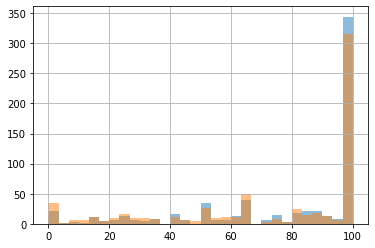

In [12]:
ab.f1_xlm.hist(bins=30, alpha=0.5)
ab.f1_wangchan.hist(bins=30, alpha=0.5)

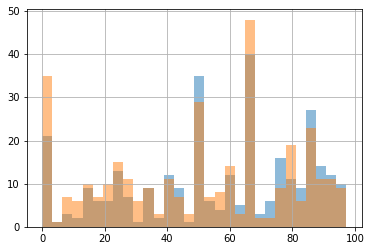

In [13]:
#plot only non-exact matches
ab[ab.f1_xlm<100].f1_xlm.hist(bins=30, alpha=0.5)
ab[ab.f1_wangchan<100].f1_wangchan.hist(bins=30, alpha=0.5)

In [14]:
#difference in exact matches
(ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum(), ((ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum()) / ab.shape[0]

(30, 0.045871559633027525)

In [15]:
#difference in f1 = 0
(ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum(), ((ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum()) / ab.shape[0]

(13, 0.019877675840978593)

In [16]:
#difference in f1 < 50
(ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum(), ((ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum()) / ab.shape[0]

(41, 0.06269113149847094)

#### Token-level F1 vs Fuzziness

Similar patterns suggest we might have same relative performance despite token-level (word, syllable, character) but we will try anyways.

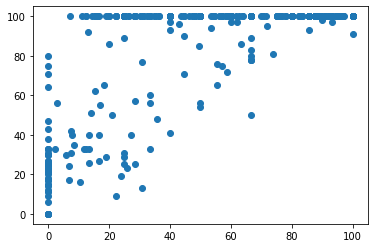

In [17]:
plt.scatter(df_wangchan.f1, df_wangchan.partial_ratio)

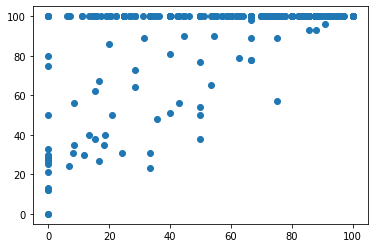

In [18]:
plt.scatter(df_xlm.f1, df_xlm.partial_ratio)

#### Contexts with sub-50 F1

In [19]:
wangchan_low =  df_wangchan[df_wangchan.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
wangchan_low = wangchan_low[wangchan_low.context>1].reset_index(drop=True)
wangchan_low

,index,context
0,แอนนาเบลล์ (อังกฤษ: annabelle) เป็นตุ๊กตาผ้ารูปเรก,5
1,ในคริสต์ศตวรรษที่ 19 ชาติมหาอำนาจยุโรปประสบปัญหากั,4
2,องค์การสุรา กรมสรรพสามิต (อังกฤษ: the liquor disti,4
3,การยุบสภาผู้แทนราษฎรไทย คือ การทำให้ความเป็นสมาชิก,3
4,การทำให้เป็นอาณานิคมของยุโรปในทวีปอเมริกา เกิดจากย,3
5,พังโคน เป็นอำเภอที่ตั้งอยู่เกือบกึ่งกลางจังหวัดสกล,3
6,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: nineteen eighty-four),3
7,อุโมงค์ฐานก็อทฮาร์ท (เยอรมัน: gotthard-basistunnel,3
8,"จอรัลด์ ""เกอร์รี"" โจเซฟ เพย์ตัน (ไอริช: gerald ""ge",3
9,เกิดเมื่อวันที่ 10 มีนาคม ค.ศ. 1924 (ตรงกับ พ.ศ. 2,3


In [20]:
xlm_low =  df_xlm[df_xlm.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
xlm_low = xlm_low[xlm_low.context>1].reset_index(drop=True)
xlm_low

,index,context
0,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: Beruseruku; อั,3
1,เส้นทางสายไหม (อังกฤษ: Silk Road หรือ Silk Route),3
2,แอนนาเบลล์ (อังกฤษ: Annabelle) เป็นตุ๊กตาผ้ารูปเรก,3
3,องค์การสุรา กรมสรรพสามิต (อังกฤษ: The Liquor Disti,3
4,เศวตัมพร หรือ เศวตามพร (สันสกฤต: श्वेतांबर สะ เหฺว,3
5,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: Nineteen Eighty-Four),3
6,ปลาใบขนุน หรือที่นิยมเรียกและรู้จักกันในชื่อภาษาแต,2
7,มโพฟูขึ้นชกมวยสากลครั้งแรกเมื่อ 29 มีนาคม พ.ศ. 254,2
8,อุโมงค์ฐานก็อทฮาร์ท (เยอรมัน: Gotthard-Basistunnel,2
9,โกปาเดลเรย์ รอบชิงชนะเลิศปี 2017 เป็นการแข่งขันฟุต,2


We can confirm this is not because of translation since `wangchanberta` also underperforms in Thai-only contexts.

In [21]:
#top wangchan misses vs xlm gets it
wx = wangchan_low.merge(xlm_low, how='left', on='index')
wx[wx.context_y.isna()]

,index,context_x,context_y
0,แอนนาเบลล์ (อังกฤษ: annabelle) เป็นตุ๊กตาผ้ารูปเรก,5,NaN
1,ในคริสต์ศตวรรษที่ 19 ชาติมหาอำนาจยุโรปประสบปัญหากั,4,NaN
2,องค์การสุรา กรมสรรพสามิต (อังกฤษ: the liquor disti,4,NaN
3,การยุบสภาผู้แทนราษฎรไทย คือ การทำให้ความเป็นสมาชิก,3,NaN
4,การทำให้เป็นอาณานิคมของยุโรปในทวีปอเมริกา เกิดจากย,3,NaN
5,พังโคน เป็นอำเภอที่ตั้งอยู่เกือบกึ่งกลางจังหวัดสกล,3,NaN
6,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: nineteen eighty-four),3,NaN
7,อุโมงค์ฐานก็อทฮาร์ท (เยอรมัน: gotthard-basistunnel,3,NaN
8,"จอรัลด์ ""เกอร์รี"" โจเซฟ เพย์ตัน (ไอริช: gerald ""ge",3,NaN
10,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: beruseruku; อั,3,NaN


In [22]:
#top xlm misses vs wangchan gets it; significantly fewer
xw = xlm_low.merge(wangchan_low, how='left', on='index')
xw[xw.context_y.isna()]

,index,context_x,context_y
0,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: Beruseruku; อั,3,NaN
1,เส้นทางสายไหม (อังกฤษ: Silk Road หรือ Silk Route),3,NaN
2,แอนนาเบลล์ (อังกฤษ: Annabelle) เป็นตุ๊กตาผ้ารูปเรก,3,NaN
3,องค์การสุรา กรมสรรพสามิต (อังกฤษ: The Liquor Disti,3,NaN
4,เศวตัมพร หรือ เศวตามพร (สันสกฤต: श्वेतांबर สะ เหฺว,3,NaN
5,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: Nineteen Eighty-Four),3,NaN
8,อุโมงค์ฐานก็อทฮาร์ท (เยอรมัน: Gotthard-Basistunnel,2,NaN
10,"ชาวเบงกอล (เบงกอล: বাঙালি; อังกฤษ: Bengali, Bangal",2,NaN
12,"จอรัลด์ ""เกอร์รี"" โจเซฟ เพย์ตัน (ไอริช: Gerald ""Ge",2,NaN
13,"""กีฬาจักรยาน"" ในการแข่งขันกีฬาแห่งชาติ ครั้งที่ 42",2,NaN


### `xlmr` Exact Matches vs `wangchanberta` Non-Exact Matches

There seems to be a problem in word tokenization.

In [23]:
from pythainlp.tokenize import word_tokenize
word_tokenize('ภาษามลายู'), word_tokenize('มลายู')

(['ภาษามลายู'], ['มลายู'])

In [25]:
xlm_better_wangchan = ab[(ab.f1_xlm==100)&(ab.f1_wangchan<100)]
print(xlm_better_wangchan.shape)
xlm_better_wangchan.sort_values('f1_wangchan')

(82, 9)


,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
406,bpJegMoxglH9pw81Twcx_004,นางเอกในเรื่องสัญญารัก วันหิมะโปรยมาจากประเทศไหน,ญี่ปุ่น,เกาหลี,0.000000,17,ญี่ปุ่น,100.0,100
479,iPqFGfJfyRwBMRdpJGjR_004,ปลากัดเขียวมีชื่อเรียกทางพื้นเมืองว่าอะไร,ปลากัดอีสาน,ปลากัดป่าหางลาย,0.000000,64,ปลากัดอีสาน,100.0,100
34,4VzSiTQUkEYvvwqX2mrU_004,ปลาบู่เขือคางยื่นในแวดวงปลาสวยงามมีชื่อเรียกว่าอะไร,มังกรแยงซีเกียง,bearded worm goby,0.000000,0,มังกรแยงซีเกียง,100.0,100
500,kcBcsOOHl1AFkBBmxq6L_004,ในหนังสือแห่งความตาย เมืองไทนิสมีบทบาทเป็นตำนานเรื่องใด,ตำนานในสวรรค์,จักรวาลวิทยาของชาวอียิปต์โบราณ,0.000000,15,ตำนานในสวรรค์,100.0,100
47,5tqFr8zFIJvE6uQqXJ7H_007,ตีพิมพ์ครั้งแรกในประเทศไทยเมื่อไร,พ.ศ. 2560,สำนักพิมพ์วิบูลย์กิจ,0.000000,11,พ.ศ. 2560,100.0,100
549,n3rJc6GRdfaU4MO3Xsum_003,ใครปกครองแต่ละจังหวัด,ผู้ว่าราชการจังหวัด,,0.000000,0,ผู้ว่าราชการจังหวัด,100.0,100
475,gaBznBUpXw7qSvFaQ4kP_004,รายละเอียดของสินค้า,ใช้สำหรับงานตกแต่งภายในทั่วไป เช่น ฉากกั้นที่มีเฟรมต่างๆ หน้าบานตู้ ประตู และ หน้าต่างเข้าเฟรมต่างๆ,t line,6.896552,17,ใช้สำหรับงานตกแต่งภายในทั่วไป เช่น ฉากกั้นที่มีเฟรมต่างๆ หน้าบานตู้ ประตู และ หน้าต่างเข้าเฟรมต่างๆ,100.0,100
88,AJxNSv4lXJWFr1wg48ZN_004,ปลาก้างพระร่วงเคยถูกค้นพบที่ต่างประเทศคือที่ใด,รัฐปีนังของมาเลเซีย,ในตลาดซื้อขายปลาน้ำจืดสวยงามโดยเป็นปลาส่งออกที่ขึ้นชื่อชนิดหนึ่ง แต่อนุกรมวิธานของปลาชนิดนี้เป็นที่สับสนกันมานานและเพิ่งได้รับการจำแนกอย่างชัดเจนในปี พ.ศ. 2556 ปลาก้างพระร่วงเป็นปลาประจำถิ่นของไทย อาศัยอยู่ตามแม่น้ำลำธารที่มีกระแสน้ำไหลแรงในภาคกลาง ภาคตะวันออก และภาคใต้ของประเทศ ปัจจุบันพบมากที่สุดตามลำน้ำทางตอนใต้ของคอคอดกระที่ไหลลงสู่อ่าวไทยและตามลำน้ำแถบทิวเขาบรรทัดในภาคตะวันออก นอกจากนี้ยังมีรายงานการพบเห็นที่รัฐปีนังของมาเลเซีย,7.272727,100,รัฐปีนังของมาเลเซีย,100.0,100
375,XlXpU8w6aUcV1Y7M6VrR_004,เอ็ดเวิร์ด มโพฟู ป้องกันแชม กับใคร,อินโดนเซนต์ มทาลาเน,แอนโทนี ทเซลา ที่แอฟริกาใต้ จากนั้นขึ้นชกชนะเป็นส่วนใหญ่ จนได้ชิงแชมป์แอฟริกาใต้รุ่นซูเปอร์แบนตัมเวทที่ว่างเมื่อ 25 มกราคม พ.ศ. 2543 ชนะน็อค วูยิซิเล ติงกา,7.547170,42,อินโดนเซนต์ มทาลาเน,100.0,100
110,BVccu2vbXhlKavM15M2p_002,โอลิวีน มีอีกความหมายว่าอะไร,แร่ประกอบหิน,สีเขียวมะกอก (olive green) และยังหมายถึงว่า เป็น แร่ประกอบหิน แต่ในลักษณะที่เป็นรัตนชาติ เรียกว่า เพริดอต (peridot) ส่วนคำว่า คริโซไลต์,12.244898,100,แร่ประกอบหิน,100.0,100


#### Syllable and Character Levels

`wangchanberta` consistently underperforms in word, syllable and character tokenizations.

In [22]:
df_wangchan_syllable, metrics_wangchan_syllable = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki_syllable, metrics_wcwiki_syllable = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm_syllable, metrics_xlm_syllable = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert_syllable, metrics_mbert_syllable = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/test/cache-3536c2cdfb6da01d.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-a3f38ec505e52afd.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-34596a785f80a720.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-1f5464554ef516eb.arrow


In [23]:
df_wangchan_character, metrics_wangchan_character = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki_character, metrics_wcwiki_character = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm_character, metrics_xlm_character = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert_character, metrics_mbert_character = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/test/cache-3536c2cdfb6da01d.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-a3f38ec505e52afd.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-34596a785f80a720.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-1f5464554ef516eb.arrow


In [24]:
metrics_wangchan, metrics_wcwiki, metrics_xlm, metrics_mbert

({'exact_match': 48.57916102841678, 'f1': 73.72159565026034},
 {'exact_match': 50.20297699594046, 'f1': 78.20811420963103},
 {'exact_match': 54.66847090663058, 'f1': 79.35555876284236},
 {'exact_match': 51.42083897158322, 'f1': 75.79187183319615})

In [25]:
metrics_wangchan_syllable, metrics_wcwiki_syllable, metrics_xlm_syllable, metrics_mbert_syllable

({'exact_match': 48.57916102841678, 'f1': 75.26453989608667},
 {'exact_match': 50.20297699594046, 'f1': 79.91758975969252},
 {'exact_match': 54.66847090663058, 'f1': 81.15183608864342},
 {'exact_match': 51.42083897158322, 'f1': 77.3011529514406})

In [26]:
metrics_wangchan_character, metrics_wcwiki_character, metrics_xlm_character, metrics_mbert_character

({'exact_match': 48.57916102841678, 'f1': 77.6488627139421},
 {'exact_match': 50.20297699594046, 'f1': 82.07507307584167},
 {'exact_match': 54.66847090663058, 'f1': 82.81788338530721},
 {'exact_match': 51.42083897158322, 'f1': 79.45429201568685})

## `wangchanberta` Trained Only on Wikipedia

Domain mismatch can be one of the key reasons `wangchanberta` underperforms multilingual models. This seems to be the cased as shown in [experiment results](https://wandb.ai/cstorm125/wangchanberta-qa?workspace=user-cstorm125)